# Install libraries

In [ ]:
%pip install --upgrade pip
%pip install matplotlib
%pip install pandas
%pip install py4j
%pip install scipy

%pip install cvxopt

%pip install networkx

#%pip install seaborn

# Handle Java Virtual Machines

## Import libraries to run/terminate JVM

In [27]:
from contextlib import closing
import os
import sys
import platform
import socket
import subprocess
from subprocess import PIPE
import tempfile
import pandas as pd
import time

import networkx as nx

import matplotlib.pyplot as plt

#import seaborn as sns
#sns.set_theme()

import numpy as np

#to send bytearrays to Java
import array

from py4j.java_gateway import JavaGateway, GatewayParameters
from py4j.java_collections import ListConverter

import scipy

from datetime import datetime

from math import sqrt
from cvxopt import matrix
from cvxopt.blas import dot
from cvxopt.solvers import qp
#help(qp)

# Download the latest version of the ERODE library

In [ ]:
import urllib.request
from pathlib import Path

base_url="https://www.erode.eu/distr/erode_python/"
files=["erode.jar","AM.ode","kaic.ode","MI.ode","test2.csv","test2B.csv","test2_pert2.csv","test2_pert2.ode","test2_pert.ode","test2_pert.csv","USAir.edgelist","film.edgelist","example.edgelist","EUAir.edgelist","BrazilAir.edgelist","actor.edgelist"]

for file in files:
    url=base_url+file
    urllib.request.urlretrieve(url,Path(url).name)

## Define functions to run/terminate JVM

In [40]:
class ErodeHandler:
    ## Specify path to java JDK
    #Default string. Can be changed using the constructor of erodeHandler
    #__JAVA_PATH__="/Library/Java/JavaVirtualMachines/jdk-11.0.14.jdk/Contents/Home/bin/java"
    #__JAVA_PATH__="/usr/lib/jvm/java-8-openjdk-amd64/Contents/Home/bin/java"
    __JAVA_PATH__="java"
    __IN_COLAB__ = False #'google.colab' in sys.modules

    ## Specify path to java JDK
    #Default string. 
    __ERODE_JAR__ = "erode.jar" #os.path.join(os.path.dirname(__file__), "erode.jar")

    ## Specify whether a new JVM shall be created, or whether we shall connect to an existing one
    # Do not change
    __STARTJVM__ = True
    
    def __init__(self,j_path=__JAVA_PATH__):
        self._java_path=j_path
        self.erode_jar=ErodeHandler.__ERODE_JAR__
        if ErodeHandler.__IN_COLAB__:
          print('I install java')
          self._install_java()

    def _install_java(self):
      !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
      os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
      #!java -version       #check java version
      ErodeHandler.__JAVA_PATH__="java"
      

    def _start_server(self):
        # find a free port
        for port in range(25333, 65545):
            with closing(socket.socket(socket.AF_INET, socket.SOCK_STREAM)) as s:
                dest_addr = ("127.0.0.1", port)
                if s.connect_ex(dest_addr):
                    break

        #ld_path = __ERODE_LIB_DIR__
        ld_path='native/osx'
        #java="java"
        java =self._java_path
        argv = [java, f'-Djava.library.path="{ld_path}"',
                    "-jar", self.erode_jar, str(port)]
        #print("argv",argv)
        if platform.system() == "Linux":
            env_ld_path = os.getenv("LD_LIBRARY_PATH")
            if env_ld_path:
                ld_path = f"{ld_path}:{env_ld_path}"
            env ={"LD_LIBRARY_PATH": ld_path}
            proc = subprocess.Popen(" ".join(argv), stdout=PIPE,
                    shell=True, env=env)
        else:
            proc = subprocess.Popen(argv, stdout=PIPE)
        proc.stdout.readline()

        self._proc=proc
        self._port=port

        time.sleep(1) # Sleep for 1 second
        return #proc, port

    def _stop_server(self):
        if ErodeHandler.__STARTJVM__:
            print('Terminating JVM and ERODE')
            time.sleep(1) # Sleep for 1 second
            self._proc.terminate()
            try:
                self._proc.wait(5)
            except subprocess.TimeoutExpired:
                self._proc.kill()
                self._proc.wait()
            print(' Completed')
        else:
            print('Nothing to terminate')

    def start_JVM(self):
        print('Starting the JVM and ERODE')
        if ErodeHandler.__STARTJVM__:
            #self._proc, self._port = _start_server()
            self._start_server()
        else:
            self._proc =-1
            self._port =25347
        gw_params = GatewayParameters(port=self._port)#, auto_convert=True)
        self._gw = JavaGateway(gateway_parameters=gw_params)

        self.int_class   =self._gw.jvm.int    # make int class
        self.double_class=self._gw.jvm.double # make double class
        self.erode = self._gw.entry_point
        #print(_proc)
        #_port
        print('  Completed')
        return self.erode #,self._proc,self._port
            
    def j_to_py_matrix(self,metrics_java):
        metrics_python= [ list(line) for line in metrics_java ]
        return metrics_python        

    def j_to_py_list(self,partition_java,type):
        partition_python= [ type(entry) for entry in partition_java ]
        return partition_python
    
    def j_to_py_2dList(self,twoDList_java,type):
        twoDList_python= [ [type(entry) for entry in row] for row in twoDList_java ]
        return twoDList_python


    #Takes in input a list of int created in python. Gives in output a corresponding array of int for java
    def py_to_j_list(self,python_int_list):
        java_int_array = self._gw.new_array(self.int_class,len(python_int_list))
        #double_array = gateway.new_array(self.double_class,1,len(partition_python))

        for i in range(len(python_int_list)):
            java_int_array[i]=python_int_list[i]
        
        return java_int_array
    
    #Takes in input a list of int created in python. Gives in output a corresponding array of int for java
    def py_to_j_matrix(self,python_int_matrix):
        
        java_int_matrix = self._gw.new_array(self.int_class,len(python_int_matrix),len(python_int_matrix))
        
        for i in range(len(python_int_matrix)):
            for j in range(len(python_int_matrix)):
                java_int_matrix[i][j]=python_int_matrix[i][j]
        
        return java_int_matrix
    
    #Takes in input a list of int created in python. Gives in output a corresponding array of int for java
    def py_to_j_list_double(self,python_double_list):
        java_double_array = self._gw.new_array(self.double_class,len(python_double_list))

        for i in range(len(python_double_list)):
            java_double_array[i]=python_double_list[i]
        
        return java_double_array

    def matrix_to_upper_diagonal(m):
        l=[]
        for i in range(len(m)):
            for j in range(i+1,len(m)):
                l.append(m[i][j])
        return l
    
    def computeParamsToMakeApprox_BE_FE(self,be):
        red_name= "be"
        if not be:
            red_name="fe"
        if not self.erode.hasLatestAxB():   
            print("Compute an approx"+red_name+" (run approx"+red_name+") before searching for parameters that make it an exact "+red_name)
            return

        A_java= self.erode.getLatestAxB_A()
        A=self.j_to_py_2dList(A_java,float)
        print("A")
        print(A)

        B_java= self.erode.getLatestAxB_B()
        B=self.j_to_py_list(B_java,float)
        print("B")
        print(B)
        

        p0_java=self.erode.getLatestAxB_p0()
        p0=self.j_to_py_list(p0_java,float)
        p0_m=matrix(np.array(p0))

        eyep0=np.eye(len(p0))
        eyep0_m=matrix(np.array(eyep0))
        
        zerosA=np.zeros((len(A),len(A[0])) )
        zerosA_m=matrix(np.array(zerosA))

        zerosB=np.zeros((len(B),1))
        zerosB_m=matrix(np.array(zerosB))

        A_m=matrix(np.array(A))
        B_m=matrix(np.array(B))

        try:
            # #qp(mu*S, -pbar, G, h, A, b)
            # #qp(P=eye(size(p0,2)), q=-p0, G=zeros(size(A,1),size(A,2)), h=zeros(1,size(b,2)), A=A, b=b) #, solver, initvals)
            print("We now find the optimal solution")
            #Rank(A) < p or Rank([P; A; G]) < n
            #if(sum(isinf(p) + isnan(p)) > 0 || norm(A*p - b') > (10^-10))
            p0_Opt=qp(P=eyep0_m, q=-p0_m, G=zerosA_m, h=zerosB_m, A=A_m, b=B_m) #, solver, initvals)

            variables=self.erode.getVariables()
            parameters=self.erode.getParameters()
            vars_pars=list(variables) + list(parameters)
            optimalParams=p0_Opt['x']
            for v,p in zip(vars_pars,optimalParams):
                print(v,"=",p)
            return optimalParams
        except ValueError as e:
            print('The optimization problem could not be solved. Likely the matrix A is not full rank.')
            print(" Error message: ",e)
        return None
    
    def computeParamsToMakeApprox_BE(self):
        self.computeParamsToMakeApprox_BE_FE(be=True)
    
    def computeParamsToMakeApprox_FE(self):
        self.computeParamsToMakeApprox_BE_FE(be=False)

# Use ERODE

## Start ERODE and VM

In [41]:
#Always start ERODE on a JVM
erodeHandler = ErodeHandler()
erode=erodeHandler.start_JVM()
type(erode)

Starting the JVM and ERODE
  Completed


py4j.java_gateway.JavaObject

## Set scale and tolearnce
- Scale: the number of digits to be considered when updating counters of BE/FE, default 20
- Tolerance: used to compare counters up to a tolerance when splitting blocks (default 1E-scale, e.g. 1E-20)

We recommend the use of setScale, that sets tolerance to 1E-scale, connecting scale and tolerance. 
- For specific needs, one might be interested in having specific tolearnces

In [28]:
# set scale to 15, and tolerance to 1E-15
#erode.setScale(15)

# set scale to 15, and tolerance to 0.5
#erode.setSCALEandSpecificTolerance(15,0.5)

## Tests

### Import Affine systems

#### From CSV files

In [15]:
erode.importAffine("test2.csv","test2B.csv",True)
nVars=erode.getVariablesNum()
print('The loaded model has',nVars,'variables')
print(erode.getModelString())

The loaded model has 3 variables
test2.csv: 2 parameters, 2 reactions, 3 species.
Parameters:
[p0 1.0, p1 1.0]
Species:
[S0, S1, S2]
 Reactions:
[S1-- (p0) -->S0+S1, S2-- (p1) -->S0+S2]


In [114]:
erode.importAffine("test2_pert2.csv","test2B.csv",False)
nVars=erode.getVariablesNum()
print('The loaded model has',nVars,'variables')
print(erode.getModelString())

The loaded model has 3 variables
test2_pert2.csv:  2 reactions, 3 species.
Species:
[S0, S1, S2]
 Reactions:
[S0-- (1.0) -->S0+S1, S0-- (1.1) -->S0+S2]


#### From lists

In [52]:
# 3,3,3
# 2,1,1
# 3,1,1.1
num_variables=3
rows=[2,3]
columns=[1,1]
values=[1,1.1]

# 0
# 0
# 0
B=[0,0,0]

rows_j    = erodeHandler.py_to_j_list(rows)
columns_j = erodeHandler.py_to_j_list(columns)
values_j  = erodeHandler.py_to_j_list_double(values)
B_j  = erodeHandler.py_to_j_list_double(B)

erode.importAffine(num_variables, rows_j, columns_j, values_j,B_j);

nVars=erode.getVariablesNum()
print('The loaded model has',nVars,'variables')
print(erode.getModelString())

The loaded model has 3 variables
fromArrays:  2 reactions, 3 species.
Species:
[S0, S1, S2]
 Reactions:
[S0-- (1.0) -->S0+S1, S0-- (1.1) -->S0+S2]


#### From bytesarray: 1) Works only is values are all int or all double! 2) For the time being we don't pass B 

In [121]:
# 3,3,3
# 2,1,1
# 3,1,1.1
num_variables=3
rows=[2,3]
columns=[1,1]

#values=[1,1.1] #Values of mixed type are not supported!
#values=[1,1]    ; entries_are_doubles=False
values=[1.0,1.1] ; entries_are_doubles=True



# 0
# 0
# 0
#B=[0,0,0]
#since it is zero, we do not pass B

#We took inspiration from:
#https://stackoverflow.com/questions/36453353/using-py4j-to-send-matrices-to-from-python-to-java-as-int-arrays
rows_arr = array.array('i', rows);
columns_arr = array.array('i', rows);
if entries_are_doubles:
    values_arr = array.array('d', values);
else:
    values_arr = array.array('i', values);
    
if sys.byteorder != 'big':
    rows_arr.byteswap()
    columns_arr.byteswap()
    values_arr.byteswap()
rows_buf = bytearray(rows_arr.tobytes())
columns_buf = bytearray(columns_arr.tobytes())
values_buf = bytearray(values_arr.tobytes())


erode.importAffine(num_variables,2,rows_buf,columns_buf,values_buf,entries_are_doubles);

nVars=erode.getVariablesNum()
print('The loaded model has',nVars,'variables')
print(erode.getModelString())

The loaded model has 3 variables
fromArrays:  2 reactions, 3 species.
Species:
[S0, S1, S2]
 Reactions:
[S1-- (1.0) -->2*S1, S2-- (1.1) -->2*S2]


### Import and reduce ODEs

In [6]:
# Load the AM model https://bmcsystbiol.biomedcentral.com/articles/10.1186/1752-0509-8-84
# we use a variant with all parameters set to one
erode.loadModel("AM.ode")
print('We have loaded model',erode.getModelName())
print(erode.getModelString())

We have loaded model AM.ode
AM.ode: 4 parameters, 4 reactions, 3 species.
Parameters:
[p1 1.0, p2 1.0, p3 1.0, p4 1.0]
Species:
[x0, x1, x2]
 Reactions:
[x0+x2-- (p1) -->x1+x2, x0+x2-- (p2) -->x0+x1, x0+x1-- (p3) -->2*x0, x1+x2-- (p4) -->2*x2]


In [7]:
obtained = erode.computeBE();
print()
print(type(obtained))
print()
print(erode.getPartitionString(obtained))


<class 'py4j.java_collections.JavaArray'>

The partition has 1 block out of 3 species:
Block 1, Size: 3
0-x0 
1-x1 
2-x2 



In [8]:
n_blocks=erode.getNumberOfBlocks(obtained)
print("The partition has",n_blocks,"blocks")

The partition has 1 blocks


#### We can provide custom prepartitions
- E.g., we don't want to mix x2 with the other two variables
- We just need to make a pre-pratitiong of the viariables: {{x0,x1},{x2}} 
- We do this by creating a list of int with one entry per variable. 
- The int values will denote blocks of the pre-partitions: variables with assigned same number will stay together
- E.g, we can encode {{x0,x1},{x2}} as [1,1,2]

In [9]:
pre_part=erodeHandler.py_to_j_list([1,1,2])

print("ERODE will use the following pre_partition")
print(erode.getPartitionString(pre_part))

n_blocks=erode.getNumberOfBlocks(pre_part)
print("The initial partition has",n_blocks,"blocks\n")

obtained_prep = erode.computeBE(pre_part);
#obtained_prep
print("This is the obtained partition")
print(erode.getPartitionString(obtained_prep))

ERODE will use the following pre_partition
The partition has 2 blocks out of 3 species:
Block 1, Size: 2
0-x0 
1-x1 

Block 2, Size: 1
2-x2 

The initial partition has 2 blocks

This is the obtained partition
The partition has 3 blocks out of 3 species:
Block 1, Size: 1
0-x0 

Block 2, Size: 1
1-x1 

Block 3, Size: 1
2-x2 



#### We can provide the prepartition written in the model, if any


In [10]:
pre_part=erode.getUserDefinedPartition()

print("ERODE will use the following pre_partition")
print(erode.getPartitionString(pre_part))

obtained_prep = erode.computeBE(pre_part);
#obtained_prep
print("This is the obtained partition")
print(erode.getPartitionString(obtained_prep))

ERODE will use the following pre_partition
The partition has 2 blocks out of 3 species:
Block 1, Size: 2
0-x0 
2-x2 

Block 2, Size: 1
1-x1 

This is the obtained partition
The partition has 2 blocks out of 3 species:
Block 1, Size: 2
0-x0 
2-x2 

Block 2, Size: 1
1-x1 



#### Further examples of reduction

In [11]:
obtained = erode.computeFE();
obtained
print(erode.getPartitionString(obtained))

The partition has 1 block out of 3 species:
Block 1, Size: 3
0-x0 
1-x1 
2-x2 



In [12]:
erode.loadModel("MI.ode")
print('We have loaded model',erode.getModelName())
print(erode.getModelString())
obtained = erode.computeBE();

print()
print("BE reduction of MI")
print(erode.getPartitionString(obtained))

We have loaded model MI.ode
MI.ode: 8 parameters, 8 reactions, 6 species.
Parameters:
[k1 1.0, k2 1.0, k3 1.0, k4 1.0, p1 1.0, p2 1.0, p3 1.0, p4 1.0]
Species:
[Y0, Z0, Y1, Z1, Y2, Z2]
 Reactions:
[Y0+Z0-- (k1) -->Z0+Y1, Z0+Y1-- (k2) -->Z0+Y2, Y0+Y2-- (k3) -->Y0+Y1, Y0+Y1-- (k4) -->2*Y0, Z0+Z2-- (k1) -->Z0+Z1, Z0+Z1-- (k2) -->2*Z0, Y0+Z0-- (k3) -->Y0+Z1, Y0+Z1-- (k4) -->Y0+Z2]

BE reduction of MI
The partition has 1 block out of 6 species:
Block 1, Size: 6
0-Y0 
1-Z0 
2-Y1 
3-Z1 
4-Y2 
5-Z2 



In [13]:
erode.loadModel("kaic.ode")
print('We have loaded model',erode.getModelName())
print(erode.getModelString())

print()
obtained = erode.computeFE();
print("FE reduction of KAIC")
print(erode.getPartitionString(obtained))

print()
erode.simulateODE(1.0,100,"kaic.csv")

We have loaded model kaic.ode
kaic.ode: 6 parameters, 8 reactions, 4 species.
Parameters:
[k1 0.5, k2 1, p1 1.0, p2 1.0, p3 1.0, p4 1.0]
Species:
[OO, PP, OP, PO]
 Reactions:
[OO+PP-- (k1) -->PP+OP, PP+OP-- (k2) -->2*PP, OO+PP-- (k1) -->OO+OP, OO+OP-- (k2) -->2*OO, OO+PP-- (k1) -->PP+PO, PP+PO-- (k2) -->2*PP, OO+PP-- (k1) -->OO+PO, OO+PO-- (k2) -->2*OO]

FE reduction of KAIC
The partition has 1 block out of 4 species:
Block 1, Size: 4
0-OO 
1-PP 
2-OP 
3-PO 




#### Lists & arrays: From java to python and viceversa

In [14]:
#Convert a python list of int to a java array of int
#  This allows to specify custom initial partitions
array_java=erodeHandler.py_to_j_list([1,1,2])

#Convert a java array of int to a python list of int
#  This allows to use in python a partition computed by ERODE
py_list_int=erodeHandler.j_to_py_list(array_java,int)
print(py_list_int)

py_list_float=erodeHandler.j_to_py_list(array_java,float)
print(py_list_float)

[1, 1, 2]
[1.0, 1.0, 2.0]


### Import and approximate Affine systems

In [15]:
erode.importAffine("test2_pert.csv","test2B.csv",True)
nVars=erode.getVariablesNum()
print('The loaded model has',nVars,'variables')
print(erode.getModelString())

The loaded model has 3 variables
test2_pert.csv: 3 parameters, 3 reactions, 3 species.
Parameters:
[p0 1.0, p1 1.0, p2 0.1]
Species:
[S0, S1, S2]
 Reactions:
[S1-- (p0) -->S0+S1, S2-- (p1) -->S0+S2, S0-- (p2) -->S0+S1]


#### No exact reduction with BE

In [16]:
pre_part=erodeHandler.py_to_j_list([1,2,2])

print("ERODE will use the following pre_partition")
print(erode.getPartitionString(pre_part))

n_blocks=erode.getNumberOfBlocks(pre_part)
print("The initial partition has",n_blocks,"blocks\n")

obtained_prep = erode.computeBE(pre_part);
#obtained_prep
print("This is the obtained partition")
print(erode.getPartitionString(obtained_prep))

ERODE will use the following pre_partition
The partition has 2 blocks out of 3 species:
Block 1, Size: 1
0-S0 

Block 2, Size: 2
1-S1 
2-S2 

The initial partition has 2 blocks

This is the obtained partition
The partition has 3 blocks out of 3 species:
Block 1, Size: 1
0-S0 

Block 2, Size: 1
1-S1 

Block 3, Size: 1
2-S2 



#### We reduce with eps-BE

In [17]:
pre_part=erodeHandler.py_to_j_list([1,2,2])
print("ERODE will use the following pre_partition")
print(erode.getPartitionString(pre_part))

n_blocks=erode.getNumberOfBlocks(pre_part)
print("The initial partition has",n_blocks,"blocks\n")

obtained_prep = erode.approxBE(0.1,pre_part,"p0;p1;p2");
#obtained_prep
print("This is the obtained partition")
print(erode.getPartitionString(obtained_prep))

print()
print()

print("ERODE will use the default pre_partition")
obtained_prep = erode.approxBE(0.1,"p0;p1;p2")
#obtained_prep
print("This is the obtained partition")
print(erode.getPartitionString(obtained_prep))

ERODE will use the following pre_partition
The partition has 2 blocks out of 3 species:
Block 1, Size: 1
0-S0 

Block 2, Size: 2
1-S1 
2-S2 

The initial partition has 2 blocks

This is the obtained partition
The partition has 2 blocks out of 3 species:
Block 1, Size: 1
0-S0 

Block 2, Size: 2
1-S1 
2-S2 



ERODE will use the default pre_partition
This is the obtained partition
The partition has 2 blocks out of 3 species:
Block 1, Size: 1
0-S0 

Block 2, Size: 2
1-S1 
2-S2 



##### What is the minimal change we can apply to the parameters to make the approx BE a BE? We consider the parameters given when running approxBE


In [18]:
#p0Opt=erodeHandler.computeParamsToMakeApprox_BE_FE(True)
p0Opt=erodeHandler.computeParamsToMakeApprox_BE()
#p0Opt

A
[[0.0, 1.0, -1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]]
B
[0.0, 0.0]
We now find the optimal solution
     pcost       dcost       gap    pres   dres
 0: -1.0000e+00 -1.0000e+00  2e+00  1e+00  0e+00
 1: -1.0000e+00 -1.0000e+00  2e-02  1e-02  0e+00
 2: -1.0000e+00 -1.0000e+00  2e-04  1e-04  0e+00
 3: -1.0000e+00 -1.0000e+00  2e-06  1e-06  0e+00
 4: -1.0000e+00 -1.0000e+00  2e-08  1e-08  0e+00
Optimal solution found.
S0 = 0.0
S1 = 0.0
S2 = 0.0
p0 = 1.0
p1 = 1.0
p2 = 0.0


#### We reduce with FE

In [19]:
pre_part=erodeHandler.py_to_j_list([1,2,2])

print("ERODE will use the following pre_partition")
print(erode.getPartitionString(pre_part))

n_blocks=erode.getNumberOfBlocks(pre_part)
print("The initial partition has",n_blocks,"blocks\n")

obtained_prep = erode.computeFE(pre_part);
#obtained_prep
print("This is the obtained partition")
print(erode.getPartitionString(obtained_prep))

ERODE will use the following pre_partition
The partition has 2 blocks out of 3 species:
Block 1, Size: 1
0-S0 

Block 2, Size: 2
1-S1 
2-S2 

The initial partition has 2 blocks

This is the obtained partition
The partition has 2 blocks out of 3 species:
Block 1, Size: 1
0-S0 

Block 2, Size: 2
1-S1 
2-S2 



### Import and approximate general ODEs

In [20]:
erode.loadModel("test2_pert2.ode")
print(erode.getModelString())

test2_pert2.ode: 2 parameters, 2 reactions, 2 species.
Parameters:
[p1 1.0, p2 1.1]
Species:
[S1, S2]
 Reactions:
[S1-- (p1) -->2*S1, S2-- (p2) -->2*S2]


#### No reduction with BE

In [21]:
obtained_prep=erode.computeBE()
print("This is the obtained partition")
print(erode.getPartitionString(obtained_prep))

This is the obtained partition
The partition has 2 blocks out of 2 species:
Block 1, Size: 1
0-S1 

Block 2, Size: 1
1-S2 



#### We reduce with eps-BE

In [22]:
print('We want to perturb p1 and p2 (all parameters in the model)')
obtained_prep = erode.approxBE(0.1,"p1;p2");
print("This is the obtained partition")
print(erode.getPartitionString(obtained_prep))

p0Opt=erodeHandler.computeParamsToMakeApprox_BE_FE(True)

We want to perturb p1 and p2 (all parameters in the model)
This is the obtained partition
The partition has 1 block out of 2 species:
Block 1, Size: 2
0-S1 
1-S2 

A
[[1.0, -1.0, 0.0, 0.0], [0.0, 0.0, 1.0, -1.0]]
B
[0.0, 0.0]
We now find the optimal solution
     pcost       dcost       gap    pres   dres
 0: -1.1025e+00 -1.1025e+00  2e+00  1e+00  7e-18
 1: -1.1025e+00 -1.1025e+00  2e-02  1e-02  0e+00
 2: -1.1025e+00 -1.1025e+00  2e-04  1e-04  0e+00
 3: -1.1025e+00 -1.1025e+00  2e-06  1e-06  0e+00
 4: -1.1025e+00 -1.1025e+00  2e-08  1e-08  0e+00
Optimal solution found.
S1 = 0.0
S2 = 0.0
p1 = 1.05
p2 = 1.05


In [23]:
print('We want to perturb ALL parameters in the model (p1 and p2)')
obtained_prep = erode.approxBE(0.1,"ALL");
print("This is the obtained partition")
print(erode.getPartitionString(obtained_prep))

p0Opt=erodeHandler.computeParamsToMakeApprox_BE_FE(True)

We want to perturb ALL parameters in the model (p1 and p2)
This is the obtained partition
The partition has 1 block out of 2 species:
Block 1, Size: 2
0-S1 
1-S2 

A
[[1.0, -1.0, 0.0, 0.0], [0.0, 0.0, 1.0, -1.0]]
B
[0.0, 0.0]
We now find the optimal solution
     pcost       dcost       gap    pres   dres
 0: -1.1025e+00 -1.1025e+00  2e+00  1e+00  7e-18
 1: -1.1025e+00 -1.1025e+00  2e-02  1e-02  0e+00
 2: -1.1025e+00 -1.1025e+00  2e-04  1e-04  0e+00
 3: -1.1025e+00 -1.1025e+00  2e-06  1e-06  0e+00
 4: -1.1025e+00 -1.1025e+00  2e-08  1e-08  0e+00
Optimal solution found.
S1 = 0.0
S2 = 0.0
p1 = 1.05
p2 = 1.05


#### No reduction with FE

In [24]:
obtained_prep=erode.computeFE()
print("This is the obtained partition")
print(erode.getPartitionString(obtained_prep))

This is the obtained partition
The partition has 2 blocks out of 2 species:
Block 1, Size: 1
0-S1 

Block 2, Size: 1
1-S2 



#### We reduce with eps-FE

In [25]:
print('We want to perturb p1 and p2 (all parameters in the model)')
obtained_prep = erode.approxFE(0.5,"p1;p2");
print("This is the obtained partition")
print(erode.getPartitionString(obtained_prep))

p0Opt=erodeHandler.computeParamsToMakeApprox_FE()

We want to perturb p1 and p2 (all parameters in the model)
This is the obtained partition
The partition has 1 block out of 2 species:
Block 1, Size: 2
0-S1 
1-S2 

A
[[0.0, 0.0], [-1.0, 1.0]]
B
[0.0, 0.0]
We now find the optimal solution
The optimization problem could not be solved. Likely the matrix A is not full rank.
 Error message:  Rank(A) < p or Rank([P; A; G]) < n


In [26]:
print('We want to perturb ALL parameters in the model (p1 and p2)')
obtained_prep = erode.approxFE(0.5,"ALL");
print("This is the obtained partition")
print(erode.getPartitionString(obtained_prep))

erodeHandler.computeParamsToMakeApprox_FE()

We want to perturb ALL parameters in the model (p1 and p2)
This is the obtained partition
The partition has 1 block out of 2 species:
Block 1, Size: 2
0-S1 
1-S2 

A
[[0.0, 0.0], [-1.0, 1.0]]
B
[0.0, 0.0]
We now find the optimal solution
The optimization problem could not be solved. Likely the matrix A is not full rank.
 Error message:  Rank(A) < p or Rank([P; A; G]) < n


### Debugging

In [27]:
erode.loadModel("ravi/guisepfde2.ode")
print('We have loaded model',erode.getModelName())
print(erode.getModelString())

print("\nintiial partition")
pre_part=erodeHandler.py_to_j_list([1,2,2])
print("We are going to use this initial partition")
print(erode.getPartitionString(pre_part))

print("\nBE")
obtained_prep=erode.computeBE(pre_part)
print("This is the obtained partition")
print(erode.getPartitionString(obtained_prep))


print('\napprox')
print('We want to perturb ALL parameters in the model')
obtained_prep = erode.approxBE(0.02,pre_part,"ALL");
print("This is the obtained partition")
print(erode.getPartitionString(obtained_prep))

erodeHandler.computeParamsToMakeApprox_BE()

We have loaded model guisepfde2
guisepfde2: 7 parameters, 7 reactions, 3 species.
Parameters:
[a -4.0, b 1.0, c 1.0, f 1.99, l -1.0, g 2.01, h -1.0]
Species:
[x1, x2, x3]
 Reactions:
[x1-- (f) -->x1+x2, x1-- (g) -->x1+x3, x1-- (a) -->2*x1, x2-- (b) -->x1+x2, x2-- (l) -->2*x2, x3-- (c) -->x1+x3, x3-- (h) -->2*x3]

intiial partition
We are going to use this initial partition
The partition has 2 blocks out of 3 species:
Block 1, Size: 1
0-x1 

Block 2, Size: 2
1-x2 
2-x3 


BE
This is the obtained partition
The partition has 3 blocks out of 3 species:
Block 1, Size: 1
0-x1 

Block 2, Size: 1
1-x2 

Block 3, Size: 1
2-x3 


approx
We want to perturb ALL parameters in the model
This is the obtained partition
The partition has 2 blocks out of 3 species:
Block 1, Size: 1
0-x1 

Block 2, Size: 2
1-x2 
2-x3 

A
[[0.0, 1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, -1.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, -1.0]]
B
[0.0, 0.0, 0.0]
We now f

In [28]:
erode.loadModel("ravi/guisepfde2.ode")
print('We have loaded model',erode.getModelName())
print(erode.getModelString())

print("\nintiial partition")
pre_part=erodeHandler.py_to_j_list([1,2,2])
print("We are going to use this initial partition")
print(erode.getPartitionString(pre_part))

print("\nBE")
obtained_prep=erode.computeFE(pre_part)
print("This is the obtained partition")
print(erode.getPartitionString(obtained_prep))


print('\napprox')
print('We want to perturb ALL parameters in the model')
obtained_prep = erode.approxFE(0.02,pre_part,"ALL");
print("This is the obtained partition")
print(erode.getPartitionString(obtained_prep))

erodeHandler.computeParamsToMakeApprox_FE()

We have loaded model guisepfde2
guisepfde2: 7 parameters, 7 reactions, 3 species.
Parameters:
[a -4.0, b 1.0, c 1.0, f 1.99, l -1.0, g 2.01, h -1.0]
Species:
[x1, x2, x3]
 Reactions:
[x1-- (f) -->x1+x2, x1-- (g) -->x1+x3, x1-- (a) -->2*x1, x2-- (b) -->x1+x2, x2-- (l) -->2*x2, x3-- (c) -->x1+x3, x3-- (h) -->2*x3]

intiial partition
We are going to use this initial partition
The partition has 2 blocks out of 3 species:
Block 1, Size: 1
0-x1 

Block 2, Size: 2
1-x2 
2-x3 


BE
This is the obtained partition
The partition has 2 blocks out of 3 species:
Block 1, Size: 1
0-x1 

Block 2, Size: 2
1-x2 
2-x3 


approx
We want to perturb ALL parameters in the model
This is the obtained partition
The partition has 2 blocks out of 3 species:
Block 1, Size: 1
0-x1 

Block 2, Size: 2
1-x2 
2-x3 

A
[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, -1.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0

In [29]:
erode.loadModel("ravi/checking.ode")
print('We have loaded model',erode.getModelName())
print(erode.getModelString())

print("\nintiial partition")
pre_part=erodeHandler.py_to_j_list([1,2,2])
print("We are going to use this initial partition")
print(erode.getPartitionString(pre_part))

print("\nBE")
obtained_prep=erode.computeBE(pre_part)
print("This is the obtained partition")
print(erode.getPartitionString(obtained_prep))


print('\napprox')
print('We want to perturb ALL parameters in the model')
obtained_prep = erode.approxBE(0.1,pre_part,"ALL");
print("This is the obtained partition")
print(erode.getPartitionString(obtained_prep))

erodeHandler.computeParamsToMakeApprox_BE()

We have loaded model checking
checking: 1 parameters, 2 reactions, 3 species.
Parameters:
[r 1.1]
Species:
[S0, S1, S2]
 Reactions:
[S0-- (r) -->S0+S1, S0-- (1) -->S0+S2]

intiial partition
We are going to use this initial partition
The partition has 2 blocks out of 3 species:
Block 1, Size: 1
0-S0 

Block 2, Size: 2
1-S1 
2-S2 


BE
This is the obtained partition
The partition has 3 blocks out of 3 species:
Block 1, Size: 1
0-S0 

Block 2, Size: 1
1-S1 

Block 3, Size: 1
2-S2 


approx
We want to perturb ALL parameters in the model
This is the obtained partition
The partition has 2 blocks out of 3 species:
Block 1, Size: 1
0-S0 

Block 2, Size: 2
1-S1 
2-S2 

A
[[0.0, 1.0, -1.0, 0.0], [0.0, 0.0, 0.0, 1.0]]
B
[0.0, 1.0]
We now find the optimal solution
     pcost       dcost       gap    pres   dres
 0: -6.0000e-01 -6.0000e-01  2e+00  1e+00  0e+00
 1: -6.0000e-01 -6.0000e-01  2e-02  1e-02  0e+00
 2: -6.0000e-01 -6.0000e-01  2e-04  1e-04  0e+00
 3: -6.0000e-01 -6.0000e-01  2e-06  1e-06 

### Simulate ODEs

In [30]:
#Load the KAIC model https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6244770/
# we use a variant with all parameters set to one
erode.loadModel("kaic.ode")
print('We have loaded model',erode.getModelName())
print(erode.getModelString())

print()
#simulate with time horizon 1, and provide 100 steps in the csv file
erode.simulateODE(1.0,100,"kaic")
df_csv=pd.read_csv("kaic.cdat")

#clean csv
df_csv=df_csv.iloc[:, :-1]
df_csv.set_index("# time",drop=True,inplace=True)

df_csv

We have loaded model kaic.ode
kaic.ode: 6 parameters, 8 reactions, 4 species.
Parameters:
[k1 0.5, k2 1, p1 1.0, p2 1.0, p3 1.0, p4 1.0]
Species:
[OO, PP, OP, PO]
 Reactions:
[OO+PP-- (k1) -->PP+OP, PP+OP-- (k2) -->2*PP, OO+PP-- (k1) -->OO+OP, OO+OP-- (k2) -->2*OO, OO+PP-- (k1) -->PP+PO, PP+PO-- (k2) -->2*PP, OO+PP-- (k1) -->OO+PO, OO+PO-- (k2) -->2*OO]



,OO,PP,OP,PO
# time,,,,
0.000000,2.000000,2.000000,0.000000,0.000000
0.010101,1.961170,1.961170,0.038830,0.038830
0.020202,1.925271,1.925271,0.074729,0.074729
0.030303,1.892010,1.892010,0.107990,0.107990
0.040404,1.861130,1.861130,0.138870,0.138870
...,...,...,...,...
0.959596,1.342971,1.342971,0.657029,0.657029
0.969697,1.342586,1.342586,0.657414,0.657414
0.979798,1.342218,1.342218,0.657782,0.657782


<AxesSubplot:xlabel='# time'>

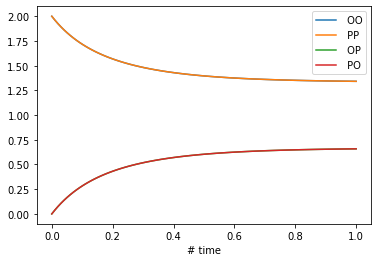

In [31]:
df_csv.plot()

## Network embeddings

OBTAINED PARTITION
[2, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1]


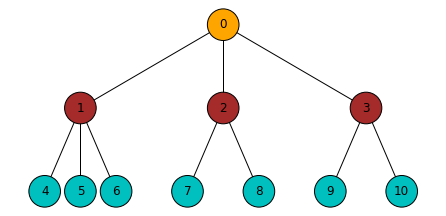

In [42]:
networkPath = "example.edgelist"
N = 11
eps = 1.0

G = nx.read_edgelist(networkPath)
pos = {'0': (1, 0), '1': (-1, -0.5), '2': (1, -0.5), '3': (3, -0.5), '4': (-1.5, -1), '5': (-1, -1), '6': (-0.5, -1), '7': (0.5, -1), '8': (1.5, -1), '9': (2.5, -1), '10': (3.5, -1) }

#compute the partition with ERODE
P = erode.reduceNetworkEpsBE(networkPath,N,eps)
P_py=erodeHandler.j_to_py_list(P,int)
print("OBTAINED PARTITION")
print(P_py)

plt.figure(figsize=(6,2.8))
colors = ["c","orange","brown"]
#Plot of the network using the computed partition. Nodes with the same color belong to the same block.
nx.draw(G,pos, node_color=[colors[i-1] for i in P_py], font_color = 'k', edgecolors = "k", node_size=[1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000], with_labels=True )
plt.show()


In [64]:
#Network embedding computation

matrix= nx.adjacency_matrix(G).todense().tolist()
matrix_j=erodeHandler.py_to_j_matrix(matrix)

#P_j=erodeHandler.py_to_j_list(P_py)

E = erode.computeEmbedding(P,matrix_j)
print("NETWORK EMBEDDING")
E_py=erodeHandler.j_to_py_matrix(E)
print(E_py)

NETWORK EMBEDDING
[[0, 0, 3], [3, 1, 0], [2, 1, 0], [2, 1, 0], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1]]


## Terminate ERODE and JVM

In [26]:
#Do not forget to close ERODE and the JVM when you are done
erodeHandler._stop_server()

Terminating JVM and ERODE
 Completed
